In [15]:
import pandas as pd

In [16]:
chunksize = 2_500_000
file_path = "rba-dataset/rba-dataset.csv"

training_df = pd.DataFrame()
testing_df = pd.DataFrame()

# Processa o CSV em chunks
for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
    if i < 3:  # Primeiros 3 chunks vão para o dataframe de treinamento
        training_df = pd.concat([training_df, chunk], ignore_index=True)
    elif i == 3:  # O último chunk vai para o dataframe de teste
        testing_df = chunk.head(1_000_000)
        break

print(f"Training DataFrame: {len(training_df)} linhas")
print(f"Test DataFrame: {len(testing_df)} linhas")


Training DataFrame: 7500000 linhas
Test DataFrame: 1000000 linhas


# Pré-Processamento

In [4]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(df):
    """Função para alterar as colunas categóricas para numéricas"""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    le = LabelEncoder()

    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    return df

In [ ]:
# separa test_df em eval e test
eval_df = testing_df.iloc[:500_000]
test_df = testing_df.iloc[500_000:]

# remove as 3 colunas de label
train_df = training_df.iloc[:, :-3]
test_df = test_df.iloc[:, :-3]

# remove colunas desnecessárias
train_df = train_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])
test_df = test_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])
eval_df = eval_df.drop(columns=['Round-Trip Time [ms]', 'index', 'User ID'])

In [6]:
# transforma as colunas categóricas em numéricas
train_df = encode_categorical_columns(train_df)
test_df = encode_categorical_columns(test_df)
eval_df = encode_categorical_columns(eval_df)

# Treinamento

## Isolation Forest v2

Esse modelo não difere em nada em relação ao baseline exceto pela quantidade de dados treinados. Assim, pode ser considerado uma baseline alternativa.

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = IsolationForest(n_estimators=1000, contamination='auto')
model.fit(train_df)

IsolationForest(n_estimators=1000)

In [9]:
# Avalia o modelo com função predict
y_pred = model.predict(eval_df.iloc[:, :-3])
print(y_pred[:10])
print(set(y_pred))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
{np.int64(1), np.int64(-1)}


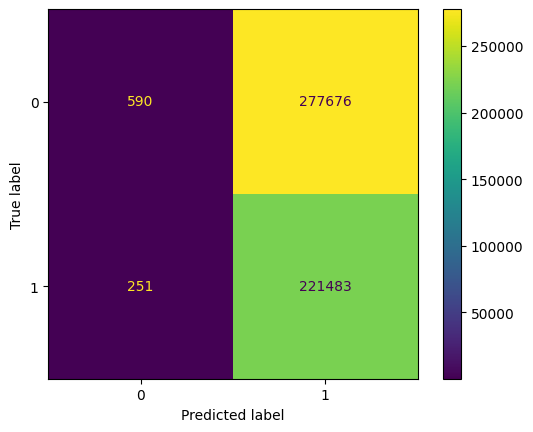

In [10]:
# Confusion Matrix
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_true = [1 if x == True else 0 for x in eval_df['Login Successful']]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Calculando usando decision_function

In [12]:
# Calcula média e desvio padrão dos scores sobre o dataset de treino
train_scores = model.decision_function(train_df)
print(train_scores.mean())
print(train_scores.std())
print("Mean + 2std: ", train_scores.mean() + 2 * train_scores.std())
threshold_train = train_scores.mean() + 2 * train_scores.std()

0.006265609303766411
0.039805937499471505
Mean + 2std:  0.08587748430270942


In [11]:
anomaly_scores = model.decision_function(eval_df.iloc[:, :-3])

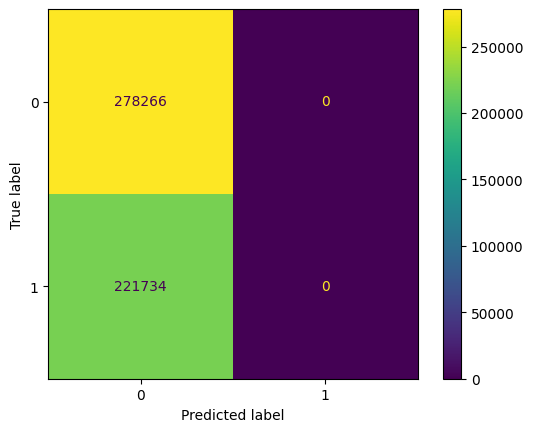

In [13]:
y_pred = [1 if x > threshold_train else 0 for x in anomaly_scores]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Parâmetros do Modelo

In [14]:
model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 1000,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Isolation Forest v3
Fazemos uma breve análise dos parâmetros dos estimadores do modelo anterior e rodamos um novo modelo com alguns parâmetros alterados, por fim de experimentação.

In [16]:
model_v3 = IsolationForest(n_estimators=10000, contamination='auto', max_features=0.7)
model_v3.fit(train_df)

IsolationForest(max_features=0.7, n_estimators=10000)

### Avalia modelo usando predict

In [17]:
# Avalia o modelo com função predict
y_pred = model_v3.predict(eval_df.iloc[:, :-3])
print(y_pred[:10])
print(set(y_pred))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
{np.int64(1), np.int64(-1)}


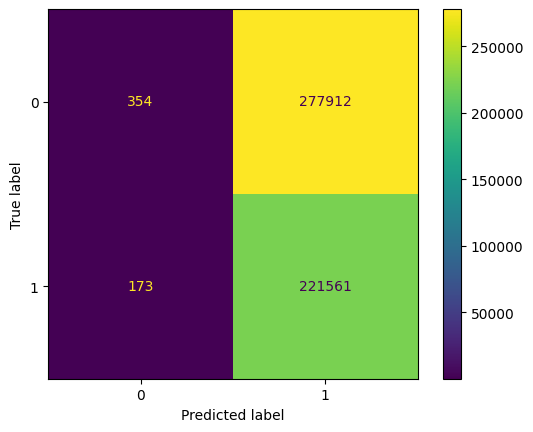

In [18]:
# Confusion Matrix
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_true = [1 if x == True else 0 for x in eval_df['Login Successful']]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# XG Boost Model

Esse modelo parece ter uma performance muito boa, mas o custo computacional de rodá-lo está meio alto. Isso talvez possa ser resolvido pela otimização do código.

Resultados:
Execução 1 -
    Tempo de treino: 7m 19s
    Métricas: validation_0-auc:0.99951	validation_0-error:0.00525	validation_1-auc:0.97850	validation_1-error:0.00529

In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
class LoginSecurityClassifier:
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.model = None
        self.feature_names = None
        
    def preprocess_features(self, df, training=True):
        """
        Faz o pré-processamento de features categóricas e numéricas.
        Retorna as features processadas prontas para treinamento ou inferência.
        """
        df_processed = df.copy()
        
        numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
        categorical_features = df.select_dtypes(include=['object', 'category']).columns
        
        for feature in categorical_features:
            if training:
                self.label_encoders[feature] = LabelEncoder()
                df_processed[feature] = self.label_encoders[feature].fit_transform(df[feature].astype(str))
            else:
                # lida com valores desconhecidos
                unique_values = self.label_encoders[feature].classes_
                df_processed[feature] = df[feature].map(lambda x: x if x in unique_values else unique_values[0])
                df_processed[feature] = self.label_encoders[feature].transform(df_processed[feature])
        
        if training:
            df_processed[numeric_features] = self.scaler.fit_transform(df[numeric_features])
        else:
            df_processed[numeric_features] = self.scaler.transform(df[numeric_features])
            
        if training:
            self.feature_names = df_processed.columns.tolist()
        
        return df_processed

    def train(self, X, y):
        """
        Treina o modelo de classificação.
        """
        X_processed = self.preprocess_features(X, training=True)
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_processed, y, test_size=0.2, random_state=42, stratify=y
        )
        
        self.model = XGBClassifier(
            scale_pos_weight=len(y_train[y_train == 0])/len(y_train[y_train == 1]), # lida com desbalanceamento
            learning_rate=0.01,
            n_estimators=1000,
            max_depth=4, # previne overfitting
            min_child_weight=6, # previsoes mais conservadoras
            subsample=0.8, # reduz overfitting
            colsample_bytree=0.8, # reduz overfitting
            eval_metric=['auc', 'error'],
            early_stopping_rounds=50,
            random_state=42
        )
        
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100
        )
        
        return self
    
    def predict(self, X, threshold=0.5):
        """
        Faz a predição de um conjunto de features.
        """
        X_processed = self.preprocess_features(X, training=False)
        probabilities = self.model.predict_proba(X_processed)
        
        return (probabilities[:, 1] >= threshold).astype(int)
    
    def explain_predictions(self, X, num_features=10):
        """
        Mostra as features mais importantes para a predição.
        """
        # TODO
        return
    
    def evaluate(self, X, y):
        """
        Avalia o modelo com base em um conjunto de features e labels.
        """
        predictions = self.predict(X)
        
        report = {
            'classification_report': classification_report(y, predictions),
            'confusion_matrix': confusion_matrix(y, predictions),
            'feature_importance': dict(zip(
                self.model.feature_names_in_, self.model.feature_importances_
            ))
        }
        
        return report


In [19]:
classifier = LoginSecurityClassifier()

In [20]:
# Rename columns to remove spaces, brackets and special characters
training_df.columns = training_df.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)
print(training_df.columns)

Index(['index', 'Login_Timestamp', 'User_ID', 'Round_Trip_Time__ms_',
       'IP_Address', 'Country', 'Region', 'City', 'ASN', 'User_Agent_String',
       'Browser_Name_and_Version', 'OS_Name_and_Version', 'Device_Type',
       'Login_Successful', 'Is_Attack_IP', 'Is_Account_Takeover'],
      dtype='object')


In [21]:
# altera coluna Login Successful para ter valores 1 (True) e 0 (False)
X = training_df.iloc[:, :-1].copy()
# y é a última coluna
y = training_df.iloc[:, -1].map({True: 1, False: 0}).copy()

In [25]:
classifier.train(X, y)

[0]	validation_0-auc:0.95742	validation_0-error:0.04223	validation_1-auc:0.89339	validation_1-error:0.04247
[100]	validation_0-auc:0.99947	validation_0-error:0.00557	validation_1-auc:0.98021	validation_1-error:0.00559
[130]	validation_0-auc:0.99951	validation_0-error:0.00525	validation_1-auc:0.97850	validation_1-error:0.00529


In [26]:
# altera colunas de teste para remover espaços, colchetes e caracteres especiais
testing_df.columns = testing_df.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)
print(testing_df.columns)

Index(['index', 'Login_Timestamp', 'User_ID', 'Round_Trip_Time__ms_',
       'IP_Address', 'Country', 'Region', 'City', 'ASN', 'User_Agent_String',
       'Browser_Name_and_Version', 'OS_Name_and_Version', 'Device_Type',
       'Login_Successful', 'Is_Attack_IP', 'Is_Account_Takeover'],
      dtype='object')


In [27]:
X_test = testing_df.iloc[:, :-1].copy()
y_test = testing_df.iloc[:, -1].map({True: 1, False: 0}).copy()

In [44]:
#predictions = classifier.predict(X_test)
# demorou muito para rodar, então comentei

In [29]:
#classifier.feature_names = classifier.model.feature_names_in_
N_SAMPLES = 1000

In [30]:
# get random batch from X_test with at least one anomaly
is_anomaly_present = False
while not is_anomaly_present:
    X_batch = X_test.sample(N_SAMPLES, random_state=42)
    y_batch = y_test.loc[X_batch.index]
    if set(y_batch) == {0, 1}:
        print("Set de teste: ", set(y_batch))
        is_anomaly_present = True

KeyboardInterrupt: 

In [31]:
# Run through batches and save predictions
predictions = []
X_batch = X_test.sample(N_SAMPLES, random_state=42)
y_batch = y_test.loc[X_batch.index]
for i in range(0, N_SAMPLES, 100):
    predictions.extend(classifier.predict(X_batch.iloc[i:i+100]))

KeyboardInterrupt: 

In [32]:
y_batch = y_test[y_test == 1]
print("Anomalias: ", len(y_batch))
X_batch = X_test.loc[y_batch.index]
predictions = classifier.predict(X_batch)
print("Predições: ", predictions)

Anomalias:  7
Predições:  [1 0 0 1 1 1 1]


In [33]:
predictions = classifier.predict(X_batch)
eval_results = classifier.evaluate(X_batch, y_batch)
print(eval_results['classification_report'])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.71      0.83         7

    accuracy                           0.71         7
   macro avg       0.50      0.36      0.42         7
weighted avg       1.00      0.71      0.83         7



/home/adao/Repos/CyberAI/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adao/Repos/CyberAI/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adao/Repos/CyberAI/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
for key, value in eval_results['feature_importance'].items():
    print(f"{key}: {value:.2f}")

index: 0.03
Login_Timestamp: 0.03
User_ID: 0.04
Round_Trip_Time__ms_: 0.00
IP_Address: 0.02
Country: 0.04
Region: 0.03
City: 0.07
ASN: 0.06
User_Agent_String: 0.34
Browser_Name_and_Version: 0.06
OS_Name_and_Version: 0.03
Device_Type: 0.19
Login_Successful: 0.03
Is_Attack_IP: 0.04


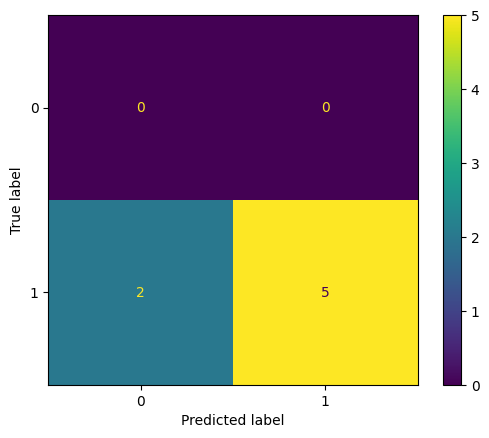

In [ ]:
# Confusion Matrix
cm = eval_results['confusion_matrix']
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [38]:
import pickle

file_name = "login_security_classifier.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(classifier, file)

### Otimização

Usar Bayesian Optimization.